# ALIGNN/ALIGNN-d graph representation for molecular structures

This notebook will guide you through encoding molecular structures into the ALIGNN/ALIGNN-d graph representation.

You will need to install `ase` for reading molecular structure files and creating molecular graphs.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import ase.io

## Read structure files

In [2]:
d_mol = ase.io.read('./data/D-alanine.mol')
l_mol = ase.io.read('./data/L-alanine.mol')

# Remove hydrogens
d_mol = d_mol[d_mol.numbers != 1]
l_mol = l_mol[l_mol.numbers != 1]

## Convert to PyG graph data

In the ALIGNN formulation, the input representation consists of two graphs: an original atomic graph ("G") and its angular graph ("A"). The cell block below uses helper functions (which have dependency on `ase`) from `graphite` to extract atom type, bond lengths, bond angles, and dihedral angles and store them in a custom PyG `Data` object with the following fields:
- `x_atm`: atom features
- `x_bnd`: bond features
- `x_ang`: bond angle and optionally dihedral angle features
    - These angle features will be substantiated with custom class methods later.
- `edge_index_bnd`: atomic graph ("G") connectivity
- `edge_index_ang`: angular graph ("A") connectivity
    - This can be further split into bond angles `edge_index_bnd_ang` and dihedral angles `edge_index_dih_ang`.

In [4]:
from ase.neighborlist import neighbor_list
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.nn import radius_graph

from graphite import line_graph, dihedral_graph
from graphite.nn import bond_angles, dihedral_angles
from graphite.data import MolData

# OVITO's default element-specific cutoffs for creating molecular bonds
ovito_cutoff = {
    ('H', 'C'): 1.74, ('H', 'N'): 1.65,  ('H', 'O'): 1.632,
    ('C', 'C'): 2.04, ('C', 'N'): 1.95,  ('C', 'O'): 1.932,
    ('N', 'N'): 1.86, ('N', 'O'): 1.842, ('O', 'O'): 1.824,
}

def atoms2molgraph(atoms, cutoff):
    """Returns edge indices of atomic bonds according to a cutoff criteria.  
    """
    i, j = neighbor_list('ij', atoms, cutoff=ovito_cutoff)
    return np.stack((i, j))

def atoms2pygdata(atoms):
    """Converts ASE `atoms` into a PyG graph data holding the molecular graph (G) and the angular graph (A).
    The angular graph holds both bond and dihedral angles.
    """
    x_atm = OneHotEncoder(sparse_output=False).fit_transform(atoms.numbers.reshape(-1,1))
    edge_index_bnd = atoms2molgraph(atoms, cutoff=ovito_cutoff)
    edge_index_bnd_ang = line_graph(edge_index_bnd)
    edge_index_dih_ang = dihedral_graph(edge_index_bnd)

    data = MolData(
        pos                = torch.tensor(atoms.positions,    dtype=torch.float),
        x_atm              = torch.tensor(x_atm,              dtype=torch.float),
        edge_index_bnd     = torch.tensor(edge_index_bnd,     dtype=torch.long),
        edge_index_bnd_ang = torch.tensor(edge_index_bnd_ang, dtype=torch.long),
        edge_index_dih_ang = torch.tensor(edge_index_dih_ang, dtype=torch.long),
    )
    return data

@torch.no_grad()
def update_bonds_and_angles(data, batch=None):
    data.x_bnd = data.bond_features('edge_index_bnd')
    data.x_bnd_ang = data.bond_angle_features('x_bnd', 'edge_index_bnd_ang')
    data.x_dih_ang = data.dihedral_angle_features('edge_index_bnd', 'edge_index_dih_ang')
    data.x_ang = data.concat_features_with_onehot('x_bnd_ang', 'x_dih_ang')
    data.edge_index_ang = torch.hstack([data.edge_index_bnd_ang, data.edge_index_dih_ang])
    return data

Using toy data, L-alanine and D-alanine, as examples, we can see that while all the bond angles are the same between the L- and D- counterparts, the dihedral angles are clearly the opposite, indicating that they are *enantiomers*. Many conventional graph neural networks cannot capture such chiral distinctions.

By the way, the angles are double-counted because the atomic graph (and its angular graph) is bidirectional under the GNN/message-passing formulation.

In [5]:
import pandas as pd

l_data = atoms2pygdata(l_mol)
d_data = atoms2pygdata(d_mol)

l_data = update_bonds_and_angles(l_data)
d_data = update_bonds_and_angles(d_data)

angles = pd.DataFrame(
    {
        'Is a dihedral angle': \
            [False]*l_data.x_bnd_ang.size(0) + [True]*l_data.x_dih_ang.size(0),
        'l-mol angles': \
            torch.cat([l_data.get_bnd_ang_vals(), l_data.get_dih_ang_vals()]), 
        'd-mol angles': \
            torch.cat([d_data.get_bnd_ang_vals(), d_data.get_dih_ang_vals()]), 
    }
)
pd.set_option("display.precision", 1)
angles

,Is a dihedral angle,l-mol angles,d-mol angles
0,False,109.7,109.7
1,False,108.1,108.1
2,False,109.7,109.7
3,False,110.8,110.8
4,False,108.1,108.1
5,False,110.8,110.8
6,False,123.2,123.2
7,False,110.4,110.4
8,False,123.2,123.2
9,False,126.4,126.4


## Define model architecture

Following DeepMind's nomenclature in the MeshGraphNets formulation, a graph (message-passing) neural network can be described as three components:
- Encoder
    - Initial encoding/embedding that transforms graph-based data into whatever format neccessary for graph convolutions or message-passing.
    - Often customized depending on the user's data format. For example, the original ALIGNN work also encodes bond types (e.g., single-bond, double-bond, triple-bond, etc.) but such information is not encoded in this example.
- Processor
    - Graph convolutions or message-passing layers. Refer to the ALIGNN paper for how it is implemented.
    - Normally does not need to be customized.
- Decoder
    - Final operation that transforms latent node/edge features into an appropriate output format.
    - Often customized by the user for a specific output format. For example, local nodal output vs. global pooled output.

In [6]:
from graphite.nn.models.alignn import Encoder, Processor, Decoder, ALIGNN

# In case it has not been made clear, this ALIGNN implementaition can encode dihedral angles
gnn = ALIGNN(
    encoder   = Encoder(num_species=3, init_bnd_dim=l_data.x_bnd.size(1), init_ang_dim=l_data.x_ang.size(1), dim=128),
    processor = Processor(num_convs=5, dim=128),
    decoder   = Decoder(node_dim=128, out_dim=2),
)

## Model forward pass

For now I'm only demonstrating a successful forward pass. Model training is currently omitted.

In [7]:
data = l_data.clone()
gnn(data.x_atm, data.x_bnd, data.x_ang, data.edge_index_bnd, data.edge_index_ang)

tensor([[ 0.1759, -0.5551],
        [ 0.2698, -0.8833],
        [-0.1591, -1.1877],
        [ 0.9761, -0.6288],
        [ 0.1351, -0.8212],
        [ 0.8487, -0.7180]], grad_fn=<AddmmBackward0>)

## Interpretation analysis

Compared to other models, ALIGNN is well suited for interpretation analysis, as the atoms, bonds, bond angles, and optionally dihedral angles are all explicitly represented as graph components. Therefore, for a given prediction, one can examine the attribution/sensitivity of each atom/bond/angle component.

Here I provide two ways to approach ALIGNN interpretation:
- gradient analysis
- summation of positive scalars

### Gradient analysis

This is a rather common and simple approach for interpreting a neural network. For a given (high-dimensional) input $\mathbf{x}$ and its corresponding (scalar) output $y$, we can compute the gradient $\frac{\delta y}{\delta \mathbf{x}}$, which tells us the attribution/sensitivity of the individual elements in $\mathbf{x}$ to the output $y$.

Let's first write a custom Decoder that pools the latent features of all components into a global scalar quantity.

In [8]:
from torch import nn
from torch_geometric.utils import scatter
from graphite.nn import MLP

class GlobalScalarDecoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.decoder = MLP([dim, dim, 1], act=nn.SiLU())

    def forward(self, h_atm, h_bnd, h_ang, x_atm_batch=None, x_bnd_batch=None, x_ang_batch=None):
        # Globally pool all atom/bond/angle components into a single feature vector
        # This operation assumes all components have the same dimensionality, 
        # which should be the case for ALIGNN.
        if x_atm_batch is not None:
            h_atm_pooled = scatter(h_atm, x_atm_batch, dim=0, reduce='mean')
            h_bnd_pooled = scatter(h_bnd, x_bnd_batch, dim=0, reduce='mean')
            h_ang_pooled = scatter(h_ang, x_ang_batch, dim=0, reduce='mean')
            h_pooled = (h_atm_pooled + h_bnd_pooled + h_ang_pooled) / 3
        else:
            h_pooled = (h_atm.mean(dim=0) + h_bnd.mean(dim=0) + h_ang.mean(dim=0)) / 3
        return self.decoder(h_pooled)

class CustomALIGNN(ALIGNN):    
    def forward(self, x_atm, x_bnd, x_ang, edge_index_bnd, edge_index_ang, x_atm_batch=None, x_bnd_batch=None, x_ang_batch=None):
        h_atm, h_bnd, h_ang = self.encoder(x_atm, x_bnd, x_ang)
        h_atm, h_bnd, h_ang = self.processor(h_atm, h_bnd, h_ang, edge_index_bnd, edge_index_ang)
        return self.decoder(h_atm, h_bnd, h_ang, x_atm_batch, x_bnd_batch, x_ang_batch)

How the pooling is performed, e.g, via summing or averaging, can be important. If the global property is instrinsic, i.e., does not depend on system size, then averaging is preferred over summing.

On a side note, when batching multiple molecular graphs into a single `data` object, remember to keep track of how `x_atm`, `x_bnd`, and `x_ang` are batched via the use of the `follow_batch` argument. Here is an example:
```python
from torch_geometric.loader import DataLoader

loader = DataLoader([l_mol_data, d_mol_data], batch_size=2, follow_batch=['x_atm', 'x_bnd', 'x_ang'])
batch = next(iter(loader))
output = gnn(batch)
```

The code below shows that indeed a scalar output is given for a molecular graph input.

In [9]:
gnn = CustomALIGNN(
    encoder   = Encoder(num_species=3, init_bnd_dim=data.x_bnd.size(1), init_ang_dim=data.x_ang.size(1), dim=128),
    processor = Processor(num_convs=5, dim=128),
    decoder   = GlobalScalarDecoder(dim=128),
)

gnn(data.x_atm, data.x_bnd, data.x_ang, data.edge_index_bnd, data.edge_index_ang)

tensor([0.0913], grad_fn=<AddBackward0>)

We will now adjust the code above to compute the gradient. However, note that computing the gradient  $\frac{\delta y}{\delta \mathbf{x}}$ requires $\mathbf{x}$ to be a continuous, smooth variable. Unfortunately, the atom type is a discrete variable, so we cannot take gradient w.r.t. atom types (technically, we could, but the value probably would not make sense).

Note that in this demo, each row in `data.x_bnd` is expressed as (dx, dy, dz, bond length), and each row in `data.x_ang` is expressed as ($\cos{\alpha}$, $\sin{\alpha}$, `onehot(angle_type)`,), where $\alpha$ is the bond/dihedral angle.

In [10]:
data.x_bnd.requires_grad_(True)
data.x_ang.requires_grad_(True)

y = gnn(data.x_atm, data.x_bnd, data.x_ang, data.edge_index_bnd, data.edge_index_ang)
grad_bnd, grad_ang = torch.autograd.grad(y, [data.x_bnd, data.x_ang])
print(grad_bnd)
print(grad_ang)

tensor([[-0.0108,  0.0180,  0.0046, -0.0053],
        [-0.0165,  0.0056, -0.0015, -0.0014],
        [-0.0005,  0.0022, -0.0099,  0.0075],
        [ 0.0061, -0.0079,  0.0168,  0.0046],
        [ 0.0064, -0.0006,  0.0118,  0.0024],
        [ 0.0083,  0.0071, -0.0029,  0.0005],
        [ 0.0032,  0.0250, -0.0148,  0.0024],
        [-0.0155,  0.0029,  0.0015, -0.0071],
        [ 0.0053,  0.0061,  0.0104, -0.0015],
        [ 0.0063, -0.0070,  0.0118, -0.0018]])
tensor([[ 0.0039, -0.0048,  0.0032, -0.0067],
        [ 0.0012, -0.0057,  0.0004, -0.0053],
        [ 0.0036, -0.0048,  0.0028, -0.0070],
        [ 0.0010, -0.0056,  0.0004, -0.0058],
        [ 0.0042, -0.0050,  0.0031, -0.0071],
        [ 0.0045, -0.0045,  0.0034, -0.0071],
        [ 0.0034, -0.0036,  0.0027, -0.0051],
        [ 0.0034, -0.0040,  0.0026, -0.0045],
        [ 0.0039, -0.0015,  0.0033, -0.0062],
        [ 0.0027, -0.0046,  0.0033, -0.0034],
        [ 0.0038, -0.0023,  0.0026, -0.0064],
        [ 0.0033, -0.0043,  0.002

### Summation of positive scalars

In the case that the scalar output is stricly positive, then one may choose to transform all components to hold positive scalars, and then sum into a single scalar. This way, the individual scalars at the atom/bond/angle components may be interpreted as contributions towards the global output.

Here is the corresponding custom Decoder.

In [11]:
from torch import nn
from torch_geometric.utils import scatter
from graphite.nn import MLP

class PositiveScalarsDecoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.transform_atm = nn.Sequential(MLP([dim, dim, 1], act=nn.SiLU()), nn.Softplus())
        self.transform_bnd = nn.Sequential(MLP([dim, dim, 1], act=nn.SiLU()), nn.Softplus())
        self.transform_ang = nn.Sequential(MLP([dim, dim, 1], act=nn.SiLU()), nn.Softplus())

    # Here I assume the data is not batched.
    def forward(self, h_atm, h_bnd, h_ang, x_atm_batch=None, x_bnd_batch=None, x_ang_batch=None):
        atm_scalars = self.transform_atm(h_atm)
        bnd_scalars = self.transform_bnd(h_bnd)
        ang_scalars = self.transform_bnd(h_ang)
        return (atm_scalars, bnd_scalars, ang_scalars)

The code below shows that the outputs are all positive scalars for all of the atoms, bonds and angles.

In [12]:
gnn = CustomALIGNN(
    encoder   = Encoder(num_species=3, init_bnd_dim=data.x_bnd.size(1), init_ang_dim=data.x_ang.size(1), dim=128),
    processor = Processor(num_convs=5, dim=128),
    decoder   = PositiveScalarsDecoder(dim=128),
)

with torch.no_grad():
    atom_contrib, bond_contrib, angle_contrib = gnn(data.x_atm, data.x_bnd, data.x_ang, data.edge_index_bnd, data.edge_index_ang)

all_sum = atom_contrib.sum() + bond_contrib.sum() + angle_contrib.sum()

atom_contrib = (atom_contrib / all_sum).flatten().numpy()
bond_contrib = (bond_contrib / all_sum).flatten().numpy()
angle_contrib = (angle_contrib / all_sum).flatten().numpy()

print('Atom contributions:', atom_contrib)
print('Bond contributions:', bond_contrib)
print('Angle contributions:', angle_contrib)

Atom contributions: [0.03052398 0.03555268 0.02969664 0.05045095 0.03889767 0.04438154]
Bond contributions: [0.01307636 0.01045977 0.01158447 0.01150025 0.01280153 0.01542057
 0.0134981  0.01336384 0.00876641 0.01289648]
Angle contributions: [0.02450122 0.03049282 0.02805981 0.02631868 0.0246814  0.02068997
 0.03398929 0.03344956 0.02415532 0.02691648 0.02139125 0.02581159
 0.04296977 0.03776326 0.04099151 0.03985896 0.04939217 0.04376965
 0.03661576 0.03531038]


## Visualizing atom, bond, and angle attributions

Since the atoms, bonds, and angles are all explicitly represented as graph components, results from the interpretation analysis can be visualized in the graph format.

For the visualization in this demo I am using `networkx`. It is probably already installed as a dependency. If not then refer to its installation guide.

In [13]:
import networkx as nx

edge_index_bnd = data.edge_index_bnd.numpy()
edge_index_ang = data.edge_index_ang.numpy()

### Original atomic graph (G)

Using `networkx`, you can color the atoms and bonds in the original atomic graph G based on their relative contributions/attributions.

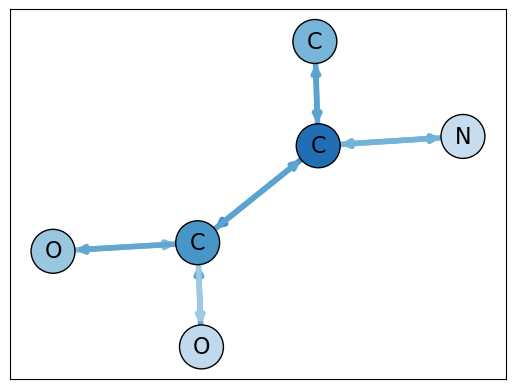

In [14]:
# Instantiate networkx graph of the original atomic graph G
G = nx.DiGraph(list(edge_index_bnd.T))

# Node labels
numbers = l_mol.numbers
number2symbol = {1: 'H', 6: 'C', 7: 'N', 8: 'O'}
G_labels = {n: number2symbol[numbers[n]] for n in G.nodes}

# Node positions. You can ask networkx to automatically determine the node positions
# For proper-looking molecular graphs, you might want to also consider using rdkit
G_pos = nx.spring_layout(G)

# Drawing options
G_options = {
    # node settings
    'labels'     : G_labels,
    'nodelist'   : range(len(atom_contrib)),
    'node_color' : atom_contrib,
    'cmap'       : plt.cm.Blues,
    'edgecolors' : 'black',
    'vmin'       : atom_contrib.min()-0.01,
    'vmax'       : atom_contrib.max()+0.01,
    
    # edge settings
    'edgelist'   : list(edge_index_bnd.T), 
    'edge_color' : bond_contrib,
    'edge_cmap'  : plt.cm.Blues,
    'width'      : 4,
    'edge_vmin'  : bond_contrib.min()-0.01,
    'edge_vmax'  : bond_contrib.max()+0.01,

    # misc. settings
    'font_size'  : 16,
    'node_size'  : 1000,
}

nx.draw_networkx(G, G_pos, **G_options)

### Angular graph (A)

We can add the angular graph (A) on top of G. Note that for visualization we only need to draw the edges (angles) of A, because the nodes (bonds) of A simply correspond to the edges of G.

Similar to the method for visualizing G, you can color the angles based on their relative contributions.

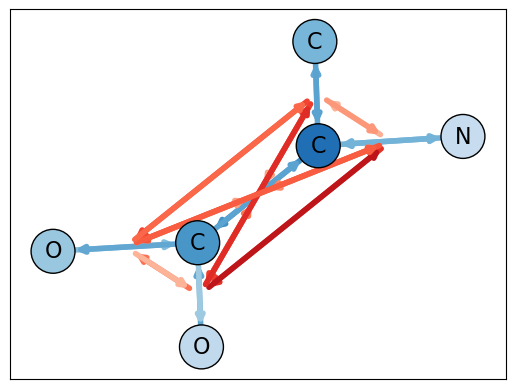

In [15]:
# Instantiate networkx graph of the angular graph A
A = nx.DiGraph(list(edge_index_ang.T))

# Node positions. Each node in A lies in the middle of its corresponding edge in G
midpoint = lambda x1, x2: (x1+x2)/2
A_pos = {}
for e in A.nodes():
    i, j = edge_index_bnd.T[e]
    A_pos[e] = midpoint(G_pos[i], G_pos[j])

# Drawing options
A_options = {
    # edge settings
    'edgelist'   : list(edge_index_ang.T), 
    'edge_color' : angle_contrib,
    'edge_cmap'  : plt.cm.Reds,
    'width'      : 4,
    'edge_vmin'  : angle_contrib.min()-0.01,
    'edge_vmax'  : angle_contrib.max()+0.01,
}

nx.draw_networkx(G, G_pos, **G_options)
nx.draw_networkx_edges(A, A_pos, **A_options)
plt.draw()

In [16]:
@torch.no_grad()
def update_bonds_and_angles_v2(data, batch=None):
    data.x_bnd = data.bond_features('edge_index_bnd')
    data.edge_index_aux_bnd = radius_graph(data.pos, r=3.0, batch=batch)
    data.x_aux_bnd = data.bond_features('edge_index_aux_bnd')
    data.x_bnd_ang = data.bond_angle_features('x_bnd', 'edge_index_bnd_ang')
    data.x_dih_ang = data.dihedral_angle_features('edge_index_bnd', 'edge_index_dih_ang')
    data.x_bnd = data.concat_features_with_onehot('x_bnd', 'x_aux_bnd')
    data.edge_index_bnd = torch.hstack([data.edge_index_bnd, data.edge_index_aux_bnd])
    data.x_ang = data.concat_features_with_onehot('x_bnd_ang', 'x_dih_ang')
    data.edge_index_ang = torch.hstack([data.edge_index_bnd_ang, data.edge_index_dih_ang])
    return data

In [17]:
l_data = atoms2pygdata(l_mol)
l_data.x_bnd = l_data.bond_features('edge_index_bnd')
l_data

MolData(pos=[6, 3], x_atm=[6, 3], edge_index_bnd=[2, 10], edge_index_bnd_ang=[2, 12], edge_index_dih_ang=[2, 8], x_bnd=[10, 4])

In [18]:
l_data.edge_index_bnd_ang.T

tensor([[2, 6],
        [2, 7],
        [6, 2],
        [6, 7],
        [7, 2],
        [7, 6],
        [0, 1],
        [0, 5],
        [1, 0],
        [1, 5],
        [5, 0],
        [5, 1]])

In [19]:
from torch_geometric.loader import DataLoader

loader = DataLoader([l_data, l_data], batch_size=2, follow_batch=['x_atm'])

batch = next(iter(loader))
batch = update_bonds_and_angles_v2(batch, batch.x_atm_batch)

In [20]:
batch.edge_index_bnd_ang.T

tensor([[ 2,  6],
        [ 2,  7],
        [ 6,  2],
        [ 6,  7],
        [ 7,  2],
        [ 7,  6],
        [ 0,  1],
        [ 0,  5],
        [ 1,  0],
        [ 1,  5],
        [ 5,  0],
        [ 5,  1],
        [ 8, 12],
        [ 8, 13],
        [12,  8],
        [12, 13],
        [13,  8],
        [13, 12],
        [ 6,  7],
        [ 6, 11],
        [ 7,  6],
        [ 7, 11],
        [11,  6],
        [11,  7]])

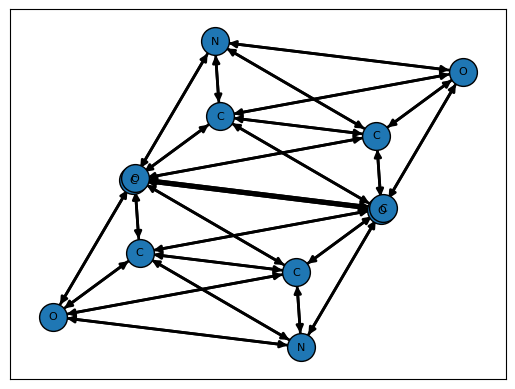

In [21]:
import networkx as nx

edge_index_bnd = batch.edge_index_bnd.numpy()
edge_index_ang = batch.edge_index_ang.numpy()

# Instantiate networkx graph of the original atomic graph G
G = nx.DiGraph(list(edge_index_bnd.T))

# Node labels
numbers = list(l_mol.numbers)*2
number2symbol = {1: 'H', 6: 'C', 7: 'N', 8: 'O'}
G_labels = {n: number2symbol[numbers[n]] for n in G.nodes}

# Node positions. You can ask networkx to automatically determine the node positions
# For proper-looking molecular graphs, you might want to also consider using rdkit
G_pos = nx.kamada_kawai_layout(G)

# Drawing options
G_options = {
    # node settings
    'labels'     : G_labels,
    'node_color' : 'tab:blue',
    'edgecolors' : 'black',
    
    # edge settings
    'edge_color' : 'black',
    'width'      : 2,

    # misc. settings
    'font_size'  : 8,
    'node_size'  : 400,
}

nx.draw_networkx(G, G_pos, **G_options)

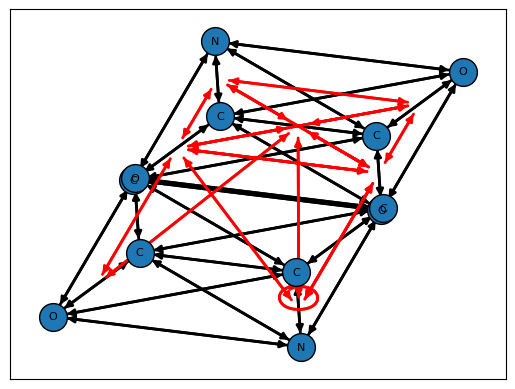

In [22]:
# Instantiate networkx graph of the angular graph A
A = nx.DiGraph(list(edge_index_ang.T))

# Node positions. Each node in A lies in the middle of its corresponding edge in G
midpoint = lambda x1, x2: (x1+x2)/2
A_pos = {}
for e in A.nodes():
    i, j = edge_index_bnd.T[e]
    A_pos[e] = midpoint(G_pos[i], G_pos[j])

# Drawing options
A_options = {
    # edge settings
    'edge_color' : 'red',
    'width'      : 2,
}

nx.draw_networkx(G, G_pos, **G_options)
nx.draw_networkx_edges(A, A_pos, **A_options)
plt.draw()